In [10]:
%cd '/home/danbi/userdata/DANBI/gugakwon/Yeominrak'
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from music21 import converter, stream, note as m21_note 
from yeominrak_processing import Gnote, Part, Tokenizer
import random as random
from typing import List, Set, Dict, Tuple
import music21 as m21
from loss import nll_loss
from torch.optim import Adam
from decode import MidiDecoder
from collections import Counter, defaultdict

/home/danbi/userdata/DANBI/gugakwon/Yeominrak
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class BasicWork:
    def __init__(self, xml_path='0_edited.musicxml') -> None:
        self.xml_path = xml_path
        self.score = converter.parse(xml_path)
        self.parts = [Part(part, i) for i, part in enumerate(self.score.parts)]
        self.tokenizer = Tokenizer(self.parts)
        self.vocab = self.tokenizer.vocab
        self.vocab_size_dict = self.tokenizer.vocab_size_dict
        self.offset_list = [part_list.measure_duration for part_list in self.parts]
        self.measure_offset_vocab = []
        self.measure_features = [self.get_feature(i) for i in range(len(self.parts))]
        max_len = max([len(part) for part in self.measure_features])
        self.measure_features = [part + [[] for _ in range(max_len - len(part))] for part in self.measure_features]
        self.part_templates = self._get_part_templates()
        
    def get_feature(self, part_idx):
      part = self.parts[part_idx]
      measure_set = []
      for measure_idx, measure in enumerate(part.measures):
          each_measure = []
          for note in measure:
              each_measure.append([part_idx, note.pitch, note.duration, note.measure_offset, note.dynamic])
          if part_idx in [2,3,4,5,6,7] and sum([note[2] for note in each_measure]) < 10.0:
              each_measure = []
          measure_set.append(each_measure) 
      return measure_set      

    def _get_part_templates(self):
        whole_part_templates = []
        for part in self.measure_features:
            part_templates = []
            for measure in part:
                temp = [note[2] for note in measure]
                part_templates.append(temp)
            # part_templates = set(tuple(temp) for temp in part_templates)
            whole_part_templates.append(part_templates)
        return whole_part_templates


In [28]:
class Bigram(BasicWork):
  def __init__(self, part_idx, xml_path='0_edited.musicxml', window_size=2, sample_len=1000 ) -> None:
    super().__init__(xml_path)
    self.part_idx = part_idx
    self.window_size = window_size
    self.sample_len = sample_len
    self.part_pitches = [note[1] for measure in self.measure_features[part_idx] for note in measure]
    # self.part_pitches = self.get_pitches_per_part()
    self.part_windowed_pitches = self.get_windowed_pitches()
    self.pitch2idx = {k:i for i, k in enumerate(self.vocab['pitch'])}
  def __len__(self):
    return len(self.part_pitches)
  
  def get_windowed_pitches(self):
    windowed_pitches = []
    for i in range(len(self.part_pitches) - self.window_size):
      windowed_pitches.append(tuple(self.part_pitches[i:i+self.window_size]))
    return [('start', self.part_pitches[0])] + windowed_pitches + [(self.part_pitches[-1], 'end')]
  
  def __getitem__(self, idx):
    pair_set = self.part_windowed_pitches[idx]
    return pair_set
    # return torch.LongTensor([self.pitch2idx[pair_set[0]]]), torch.LongTensor([self.pitch2idx[pair_set[1]]])
  
  
bigram = Bigram(7)
len(bigram)
bigrams = [bigram[i] for i in range(len(bigram))]

In [32]:
bigrams[8]

(48.0, 46.0)

In [29]:
bigram_counts = Counter(bigrams)
unigram_counts = Counter(word for word, _ in bigrams)

# 조건부 확률 계산
bigram_model = defaultdict(dict)
for (w1, w2), count in bigram_counts.items():
    bigram_model[w1][w2] = count / unigram_counts[w1]


In [83]:
bigram_model['start']

{51.0: 1.0}

In [58]:
[i for i in pitch_prob.keys()]

[51.0, 46.0, 48.0, 53.0, 39.0, 56.0, 58.0, 49.0]

In [100]:
def generate(bigram_model, max_len=20):
  pitch = ['start']
  whole_pitches = [pitch[0]]
  for _ in range(max_length):
    pitch_prob = bigram_model[pitch[0]]
    pitch = random.choices([i for i in pitch_prob.keys()], weights=[i for i in pitch_prob.values()])
    if pitch == 'end':
      break
    whole_pitches.append(pitch[0])
    
  return whole_pitches

In [106]:
dataloader = DataLoader(bigram, batch_size=1, shuffle=False)

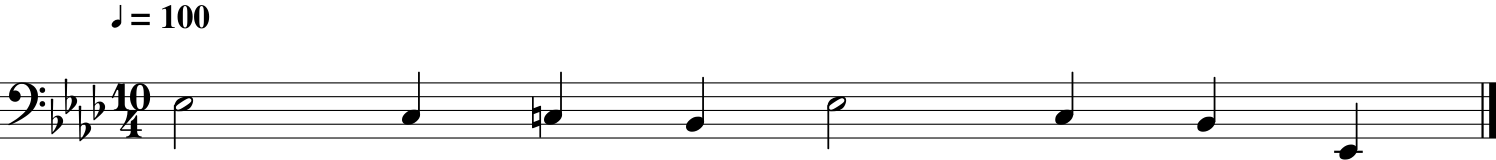

In [127]:
decoder = MidiDecoder(dataloader)
part_idx = 7
template = bigram.part_templates[7]
result = generate(bigram_model, max_len=20)[1:-1]
random_tamplate = random.choice(template)
set_result = [[part_idx, result[i], random_tamplate[i]] for i in range(len(random_tamplate))]
decoder(set_result).show()

In [101]:
generate(bigram_model, max_len=20)

['start',
 51.0,
 48.0,
 46.0,
 44.0,
 39.0,
 53.0,
 51.0,
 39.0,
 46.0,
 48.0,
 48.0,
 48.0,
 53.0,
 53.0,
 56.0,
 53.0,
 56.0,
 53.0,
 39.0,
 53.0]

In [36]:
bigram_model[51.0]

{51.0: 0.2517482517482518,
 46.0: 0.08391608391608392,
 48.0: 0.3881118881118881,
 53.0: 0.15384615384615385,
 39.0: 0.045454545454545456,
 56.0: 0.04895104895104895,
 58.0: 0.013986013986013986,
 49.0: 0.013986013986013986}

In [16]:
from collections import Counter
Counter(bigram.part_pitches)

Counter({51.0: 286,
         46.0: 298,
         48.0: 222,
         53.0: 196,
         56.0: 144,
         49.0: 9,
         34.0: 7,
         44.0: 148,
         41.0: 65,
         39.0: 97,
         58.0: 39,
         60.0: 11,
         63.0: 7})

In [5]:

class Generator(nn.Module):
  def __init__(self, input_dim=1, hidden_size=16):
    super().__init__()
    self.emb = nn.Embedding(num_embeddings=17, embedding_dim=hidden_size//2)
    self.layer1 = nn.Linear(in_features=hidden_size//2, out_features=hidden_size)
    self.layer2 = nn.Linear(in_features=hidden_size, out_features=17)
  def forward(self, x):
    # x = x.transpose(0,1)
    x = self.emb(x)
    hidden = self.layer1(x)
    hidden = torch.relu(hidden)
    out = self.layer2(hidden)
    return out.softmax(dim = -1)

model = Generator()

In [6]:


dataloader = DataLoader(bigram, batch_size=16, shuffle=True, drop_last=True)
batch = next(iter(dataloader))
optimizer = Adam(model.parameters(), lr=0.001)


In [8]:
for epoch in range(200):
  for batch in dataloader:
    pred = model(batch[0])
    loss = nll_loss(pred, batch[1].squeeze())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  if epoch % 25 == 0:  
    print(f'epoch: {epoch}, loss: {loss}')

epoch: 0, loss: 1.5717185735702515
epoch: 25, loss: 1.5471525192260742
epoch: 50, loss: 1.4083056449890137
epoch: 75, loss: 1.8745546340942383
epoch: 100, loss: 1.5264832973480225
epoch: 125, loss: 1.6528211832046509
epoch: 150, loss: 1.5180364847183228
epoch: 175, loss: 1.5632874965667725


In [9]:
def inference(model, start, end, max_len=20):
  model.eval()
  with torch.no_grad():
    idx = start
    result = []
    for _ in range(max_len):
      pred = model(torch.LongTensor([idx]))
      idx = pred.multinomial(1).item()
      result.append(idx)
      if idx == end:
        break
  return result

In [10]:
result = inference(model, 0, 16, max_len=20)
result

[11, 10, 11, 10, 8, 6, 8, 7, 7, 7, 6, 5, 7, 6, 8, 11, 10, 11, 10, 8]

In [11]:
decoder = MidiDecoder(dataloader)

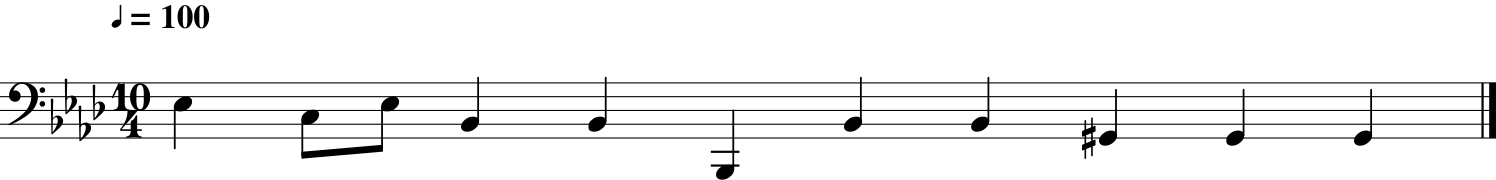

In [19]:
part_idx = 7
template = bigram.part_templates[7]
result = inference(model, 0, 16, max_len=30)
result = [bigram.vocab['pitch'][pitch] for pitch in result]
random_tamplate = random.choice(template)
set_result = [[part_idx, result[i], random_tamplate[i]] for i in range(len(random_tamplate))]
decoder(set_result).show()

In [13]:
# 각 tempate 별로 몇개의 종류가 있는지!
dataset = BasicWork()
for idx, data in enumerate(dataset.part_templates):
  print(f'part_{idx} templates:', len(data))

part_0 templates: 160
part_1 templates: 160
part_2 templates: 160
part_3 templates: 160
part_4 templates: 160
part_5 templates: 160
part_6 templates: 160
part_7 templates: 160
